<a href="https://colab.research.google.com/github/fujin55/Ai-lab-5/blob/main/exercises/05_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Classification of points (images) lying on one side of the curve - the decision boundary:
#
#
#                  (1,3)                (3,3)
#                       o-----------------o
#                      /                   \      class 0
#                     /                     \
#                    /                       \
#                   /                         \
# -----------------o  (-1,1)            (5,1)  o-------------------------------------------
#
#                              class 1

In [ ]:
import time
import os.path
import pdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
print(tf.__version__)
# if tensorflow2 use tf.compat.v1. apart tf. (see classification2 script)
tf.compat.v1.disable_eager_execution()
num_of_features = 2
num_of_epochs = 1000
num_to_show = 50

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, num_of_features])  # place for input vectors
y_ = tf.placeholder(tf.float32, shape=[None, 1])               # place for desired output of ANN

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


2.18.0


### Analytical version
(See more: https://d2l.ai/chapter_linear-regression/linear-regression.html )

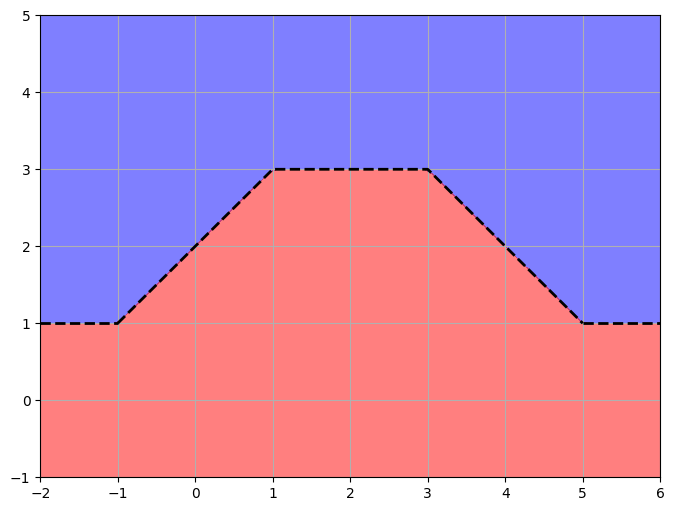

In [ ]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 2])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

k = 40.0 # waga sigmoidu

# Layer 1: 5 Neuronów
# Neuron 1: y - 1 >= 0  -> dolna podstawa
# Neuron 2: x + 2 - y >= 0 -> bok 1
# Neuron 3: -x + 6 - y >= 0 -> bok 2
# Neuron 4: 3 - y >= 0   -> górna podstawa
# Neuron 5: 1 - y >= 0   -> wszystko poniżej
IW_a = tf.Variable(tf.constant([
    [ 0.0,   k],
    [ k,   -k],
    [-k,   -k],
    [ 0.0, -k],
    [ 0.0, -k],
], dtype=tf.float32))

b1_a = tf.Variable(tf.constant([
    -k * 1,
     k * 2,
     k * 6,
     k * 3,
     k * 1
], dtype=tf.float32))

h1_a = tf.sigmoid(tf.matmul(x, tf.transpose(IW_a)) + b1_a)

# Layer 2
# iloczyn dla trapezoidu
log_trapezoid = tf.reduce_sum(tf.log(h1_a[:, 0:4] + 1e-6), axis=1, keepdims=True)
trapezoid_output = tf.exp(log_trapezoid)

# y <= 1
line_output = h1_a[:, 4:5]

# Final output (A lub = 1 - (1-A) * (1-B))
y = 1 - (1 - trapezoid_output) * (1 - line_output)

# wykres
sess = tf.Session()
sess.run(tf.global_variables_initializer())

xx, yy = np.meshgrid(np.linspace(-2, 6, 300), np.linspace(-1, 5, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]
zz = sess.run(y, feed_dict={x: grid_points})
zz = zz.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zz, levels=[-0.1, 0.5, 1.1], colors=['blue', 'red'], alpha=0.5)
plt.plot([-2, -1], [1, 1], 'k--', lw=2)
plt.plot([5, 6], [1, 1], 'k--', lw=2)
trapezoid_edges = np.array([
    [-1, 1], [1, 3], [3, 3], [5, 1]
])
plt.plot(trapezoid_edges[:, 0], trapezoid_edges[:, 1], 'k--', lw=2)
plt.grid(True)
plt.show()


### Trainable version

Step 0, Cross-Entropy Loss: 0.7229
Step 50, Cross-Entropy Loss: 0.6661
Step 100, Cross-Entropy Loss: 0.6567
Step 150, Cross-Entropy Loss: 0.6452
Step 200, Cross-Entropy Loss: 0.6415
Step 250, Cross-Entropy Loss: 0.6359
Step 300, Cross-Entropy Loss: 0.6262
Step 350, Cross-Entropy Loss: 0.6037
Step 400, Cross-Entropy Loss: 0.5610
Step 450, Cross-Entropy Loss: 0.4934
Step 500, Cross-Entropy Loss: 0.4105
Step 550, Cross-Entropy Loss: 0.3244
Step 600, Cross-Entropy Loss: 0.2505
Step 650, Cross-Entropy Loss: 0.1957
Step 700, Cross-Entropy Loss: 0.1561
Step 750, Cross-Entropy Loss: 0.1267
Step 800, Cross-Entropy Loss: 0.1032
Step 850, Cross-Entropy Loss: 0.0838
Step 900, Cross-Entropy Loss: 0.0691
Step 950, Cross-Entropy Loss: 0.0580


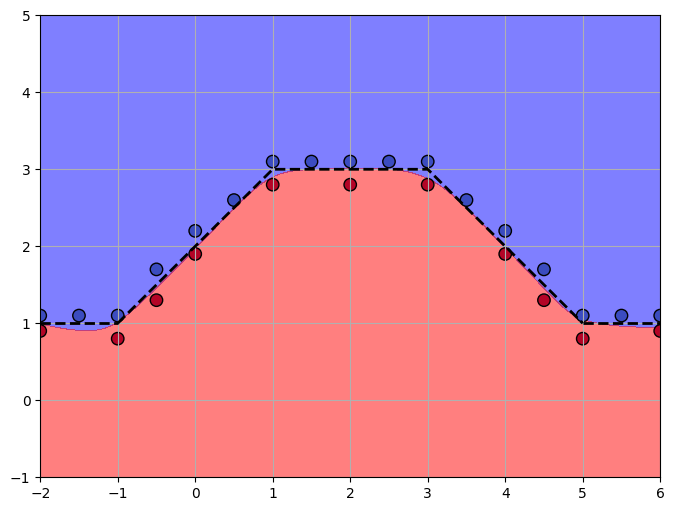

In [ ]:
# 5 neuronów po dwa wejścia i bias
IW = tf.Variable(tf.random.normal([5, 2], stddev=1.0))
b1 = tf.Variable(tf.zeros([5]))
h1 = tf.sigmoid(tf.matmul(x, tf.transpose(IW1)) + b1)

# 2 neurony po 5 wejść
IW2 = tf.Variable(tf.random.normal([2, 5], stddev=1.0))
b2 = tf.Variable(tf.zeros([2]))
h2 = tf.sigmoid(tf.matmul(h1, tf.transpose(IW2)) + b2)

# 2 wyjście 1 neuron
LW = tf.Variable(tf.random.normal([2, 1], stddev=1.0))
b3 = tf.Variable(tf.zeros([1]))
y = tf.sigmoid(tf.matmul(h2, LW) + b3)

# Entropia
cross_entropy = tf.reduce_mean(-y_ * tf.log(y + 1e-6) - (1 - y_) * tf.log(1 - y + 1e-6))

# Optymalizacja
train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Punkty na plane
train_points = np.array([
    [-2,   0.9], [-1,  0.8], [-1.5,1.1], [-0.5,     1.3], [1.5, 3.1], [4.5,   1.3], [5.5,    1.1], [5,  0.8], [6,  0.9],
    [-2,   1.1], [-1,  1.1], [0,   2.2], [1,   3.1], [2,   3.1], [3, 3.1], [4,  2.2], [5 , 1.1], [6 , 1.1],
    [0,    1.9], [1,   2.8], [2,   2.8], [3,   2.8], [4,   1.9],
    [-0.5, 1.7], [0.5, 2.6], [2.5, 3.1], [3.5, 2.6], [4.5, 1.7],
], dtype=np.float32)

train_labels = np.array([
    [1], [1], [0], [1], [0], [1], [0], [1], [1],
    [0], [0], [0], [0], [0], [0], [0], [0], [0],
    [1], [1], [1], [1], [1],
    [0], [0], [0], [0], [0],
], dtype=np.float32)

# Training
for step in range(1000):
    sess.run(train_step, feed_dict={x: train_points, y_: train_labels})
    if step % 50 == 0:
        loss_val = sess.run(cross_entropy, feed_dict={x: train_points, y_: train_labels})
        print(f"Step {step}, Cross-Entropy Loss: {loss_val:.4f}")

# wykres
xx, yy = np.meshgrid(np.linspace(-2, 6, 300), np.linspace(-1, 5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = sess.run(y, feed_dict={x: grid})
zz = zz.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.plot([-2, -1], [1, 1], 'k--', lw=2)
plt.plot([5, 6], [1, 1], 'k--', lw=2)
plt.plot(trapezoid_edges[:, 0], trapezoid_edges[:, 1], 'k--', lw=2)
plt.contourf(xx, yy, zz, levels=[-0.1, 0.5, 1.1], colors=['blue', 'red'], alpha=0.5)
plt.scatter(train_points[:, 0], train_points[:, 1], c=np.squeeze(train_labels), cmap='coolwarm', edgecolor='k', s=80)
plt.grid(True)
plt.show()

#### The training process

#### Drawing decision boundary

In [ ]:
X1, X2 = np.meshgrid(np.linspace(-4, 8, 120), np.linspace(-4,8, 120))  # grid of points in 2D plane
P = np.stack((X1.flatten(),X2.flatten()), axis=1)                    # points formated for ANN input
Y = sess.run(y_a, feed_dict={x: P})                                    # ANN outputs for flatten grid  points
Z = np.reshape(Y,X1.shape)                                           # reshaping to shape of grid
plt.contourf(X1, X2, Z, levels=[0.5, 1.0])                           # curve for level=0.5 - a decision boundary, shaded class 1 area
plt.title('v4 analytical method')
plt.show()


NameError: name 'y_a' is not defined

#### Drawing 3D mesh

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X1, X2, Z, rstride=1, cstride=1, cmap=cm.viridis)
plt.title('v4 analytical method')
plt.show()

NameError: name 'Z' is not defined

<Figure size 640x480 with 0 Axes>